In [1]:
using ForwardDiff, Plots, NLsolve, LsqFit, Optim

In [2]:
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298  # Temperature in Kelvin
sigma = 0.0098  # Surface tension in J/m² (dyne/cm converted to J/m²)
a = 270e-9  # Droplet radius in meters
xi = 0.15  # Dimensionless parameter
epsilon_r = 78.5  # Relative permittivity of water
epsilon_0 = 8.85e-12  # Permittivity of vacuum in F/m
psi_0 = 270e-3  # Surface potential in volts
lambda_D = 3.4e-9  # Debye length in meters
phi_c = 0.646  # Critical volume fraction
alpha = 0.85  # Shear effect parameter
V_drop = (4/3) * π * a^3  # Droplet volume in cubic meters

8.244795760081054e-20

In [3]:
function F_int(phi_d)
    return 4 * π * xi * sigma * (a^2) * (phi_d^2) 
end

function F_ent(phi, phi_d, gamma)
    return -3 * k_B * T * log(phi_c + phi_d - phi - alpha * gamma^2)
end

function F_elec(phi_d, phi, gamma)
    h = 2 * phi_c^(1/3) * a * ((phi).^(-1/3) - (phi_c + phi_d - alpha * gamma^2).^(-1/3))
    return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp(-h / lambda_D) / h
end


function F_tot(phi_d, phi, gamma)
    term = phi_c + phi_d - phi - alpha * gamma^2
    if term <= 0
        return Inf  # Return a large value to avoid invalid log
    end
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi_d, phi, gamma)
end


F_tot (generic function with 1 method)

In [4]:
function find_min_phi_d(phi, gamma)
    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0.0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    result = optimize(phi_d -> F_tot(phi_d, phi, gamma), lower_bound, 0.35, Brent())

    return Optim.minimizer(result), Optim.minimum(result)
end

find_min_phi_d (generic function with 1 method)

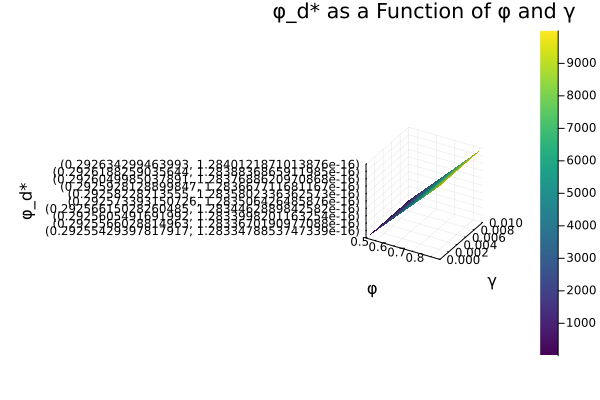

In [5]:
phi_values = range(0.45, 0.85, length=100)
gamma_values = range(0.0, 0.01, length=100)

phid_star_matrix = [find_min_phi_d(phi, gamma) for phi in phi_values, gamma in gamma_values]

surface(phi_values, gamma_values, phid_star_matrix, xlabel="φ", ylabel="γ", zlabel="φ_d*", title="φ_d* as a Function of φ and γ", c=:viridis)

plot!()

# Least Squares Fit

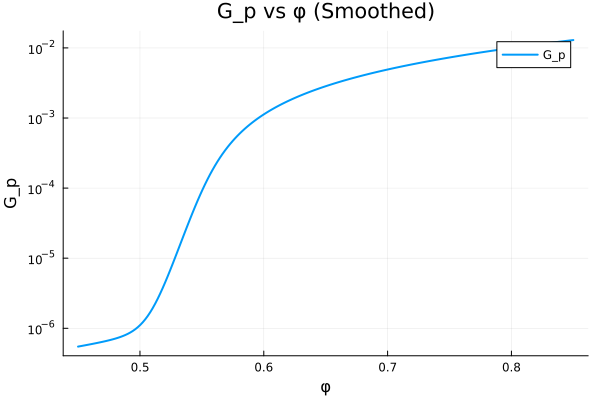

In [ ]:
phi_vals = range(0.45, 0.85, length=200)
gamma_vals = range(0, 0.01, length=200)
G_p_values = Float64[]
G_p_int_values = Float64[]
G_p_ent_values = Float64[]
G_p_elec_values = Float64[]

for phi in phi_vals
    gamma_list = Float64[]
    F_tot_star_list = Float64[]
    F_int_star_list = Float64[]
    F_ent_star_list = Float64[]
    F_elec_star_list = Float64[]
    
    for gamma in gamma_vals
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        push!(F_tot_star_list, F_tot(phi_d_star, phi, gamma))
        push!(F_int_star_list, F_int(phi_d_star))
        push!(F_ent_star_list, F_ent(phi, phi_d_star, gamma))
        push!(F_elec_star_list, F_elec(phi_d_star, phi, gamma))
    end

    # Model function for curve fitting
    model(gamma, p) = p[1] .+ p[2] .* gamma .+ p[3] .* gamma.^2
    initial_guess = [minimum(F_tot_star_list), 0.0, 0.0]
    
    fit_tot = curve_fit(model, gamma_vals, F_tot_star_list, initial_guess)
    fit_int = curve_fit(model, gamma_vals, F_int_star_list, initial_guess)
    fit_ent = curve_fit(model, gamma_vals, F_ent_star_list, initial_guess)
    fit_elec = curve_fit(model, gamma_vals, F_elec_star_list, initial_guess)
    
    second_derivative = 2 * fit_tot.param[3]
    second_derivative_int = 2 * fit_int.param[3]
    second_derivative_ent = 2 * fit_ent.param[3]
    second_derivative_elec = 2 * fit_elec.param[3]
    
    push!(G_p_values, (phi / V_drop) * second_derivative)
    push!(G_p_int_values, (phi / V_drop) * second_derivative_int)
    push!(G_p_ent_values, (phi / V_drop) * second_derivative_ent)
    push!(G_p_elec_values, (phi / V_drop) * second_derivative_elec)
end


p = plot(phi_vals, G_p_values .* a / sigma, label="G_p", lw=2, yscale=:log10)
# plot!(phi_vals, G_p_int_values .* a / sigma, label="G_p_int", lw=2)
# plot!(phi_vals, G_p_ent_values .* a / sigma, label="G_p_ent", lw=2)
# plot!(phi_vals, G_p_elec_values .* a / sigma, label="G_p_elec", lw=2)
xlabel!("φ")
ylabel!("G_p")
title!("G_p vs φ")

display(p)


In [7]:
G_p_int_values 

200-element Vector{Float64}:
    -116.34859110066715
    -117.60831908610409
    -118.8826461249824
    -120.17193070710218
    -121.47656757687635
    -122.7969964333415
    -124.13371304429937
    -125.48728349668235
    -126.85836242957896
    -128.2477163618237
       ⋮
 -128844.02449644222
 -130508.87654090417
 -132186.13468092756
 -133875.83965735775
 -135578.05188279506
 -137292.79553032242
 -139020.12418646278
 -140760.0746044915
 -142512.69262383162

In [8]:
G_p_ent_values .* a / sigma

200-element Vector{Float64}:
   3.518625420786183e-7
   3.313566526220073e-7
   3.027110200662868e-7
   2.633652345297347e-7
   2.0997942781607576e-7
   1.3820322047363252e-7
   4.237715296445374e-8
  -8.485124012436824e-8
  -2.530215153750842e-7
  -4.744952381066763e-7
   ⋮
 -33.760489777864926
 -34.348529184896734
 -34.9428410283089
 -35.54345283289507
 -36.15039211455222
 -36.76368638068936
 -37.38336313001237
 -38.00944985287449
 -38.64197403125869

In [9]:
G_p_elec_values

200-element Vector{Float64}:
 -116.35000575552121
 -117.60890967541167
 -118.8821181646862
 -120.16989689276166
 -121.47251951203349
 -122.7902679591488
 -124.12343276321553
 -125.47231335897546
 -126.83721840236544
 -128.2184660850417
    ⋮
   -1.0967468710789725e6
   -1.1164224661873323e6
   -1.1363133028613261e6
   -1.1564203394326796e6
   -1.176744514245167e6
   -1.1972868015601435e6
   -1.2180481459199598e6
   -1.2390295083904716e6
   -1.2602318406503992e6

# Interpolation + Numerical Differentiation 

In [10]:
using Interpolations

phi_vals = range(0.45, 0.85, length=200)
gamma_vals = range(0, 0.01, length=200)
G_p_values = Float64[]
G_p_int_values = Float64[]
G_p_ent_values = Float64[]
G_p_elec_values = Float64[]

for phi in phi_vals
    F_tot_star_list = Float64[]
    F_int_star_list = Float64[]
    F_ent_star_list = Float64[]
    F_elec_star_list = Float64[]
    
    for gamma in gamma_vals
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        push!(F_tot_star_list, F_tot(phi_d_star, phi, gamma))
        push!(F_int_star_list, F_int(phi_d_star))
        push!(F_ent_star_list, F_ent(phi, phi_d_star, gamma))
        push!(F_elec_star_list, F_elec(phi_d_star, phi, gamma))
    end


    itp_tot = interpolate((gamma_vals,), F_tot_star_list, Gridded(Linear()))
    itp_int = interpolate((gamma_vals,), F_int_star_list, Gridded(Linear()))
    itp_ent = interpolate((gamma_vals,), F_ent_star_list, Gridded(Linear()))
    itp_elec = interpolate((gamma_vals,), F_elec_star_list, Gridded(Linear()))

    h = 0.5 * step(gamma_vals)
    gamma_0 = h  

    second_derivative_tot = (itp_tot(gamma_0 + h) - 2 * itp_tot(gamma_0) + itp_tot(gamma_0 - h)) / h^2
    second_derivative_int = (itp_int(gamma_0 + h) - 2 * itp_int(gamma_0) + itp_int(gamma_0 - h)) / h^2
    second_derivative_ent = (itp_ent(gamma_0 + h) - 2 * itp_ent(gamma_0) + itp_ent(gamma_0 - h)) / h^2
    second_derivative_elec = (itp_elec(gamma_0 + h) - 2 * itp_elec(gamma_0) + itp_elec(gamma_0 - h)) / h^2
    
    push!(G_p_values, (phi / V_drop) * second_derivative_tot)
    push!(G_p_int_values, (phi / V_drop) * second_derivative_int)
    push!(G_p_ent_values, (phi / V_drop) * second_derivative_ent)
    push!(G_p_elec_values, (phi / V_drop) * second_derivative_elec)
end

In [11]:
G_p_values

200-element Vector{Float64}:
  0.0
  2.613333557935356e-8
  0.0
 -2.6365761020859764e-8
  0.0
  0.0
  2.6714399183119062e-8
  0.0
  0.0
 -2.706303734537837e-8
  ⋮
 -0.0003949670606638508
  0.00039591907527226027
  0.0
  0.0
  0.0003987751190974884
 -0.00039972713370589786
  0.0
  0.0
  0.000402583177531126

# Osmotic pressure